## N-Qubit Boltzmann Machine

We use a n-qubit system, where the goal is to learn the parameters of the Ising Hamiltonian:

$H = \sum_{i} \sum_{j}\sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_i^k \otimes \sigma_j^{k'} + \sum_{i}\sum_{k} h^k_i \sigma_{i}^k$

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. The explicit Hamiltonian is written as:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k \otimes \sigma_1^0 + h^{k'}_1 \sigma_0^0 \otimes \sigma_1^{k'}$

A vector state follows the numbering convention $|s_0, \dots, s_n>$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numba import njit
from itertools import product
from scipy.linalg import kron

In [2]:
# define the Pauli matrices globally
PAULI_I = np.array([[1, 0], [0, 1]], dtype=np.complex128)
PAULI_X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
PAULI_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
PAULI_Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# create an array of Pauli matrices and their labels
PAULI_MATRICES = np.array([PAULI_I, PAULI_X, PAULI_Y, PAULI_Z], dtype=np.complex128)
PAULI_LABELS = ['I', 'X', 'Y', 'Z']

In [3]:
def tensor_product(matrices):
    """Compute the tensor product of a list of matrices."""
    result = matrices[0]
    # iterate over each matrix in the list starting from the second one
    for matrix in matrices[1:]:
        result = kron(result, matrix)
    return result
 
def generate_interaction_matrices(num_qubits):
    """Constructs the tensor product of Pauli matrices for each qubit pair."""
    num_combinations = 4 ** num_qubits # total number of combinations of Pauli matrices for num_qubits
    interaction_matrices = np.empty((num_combinations, 2 ** num_qubits, 2 ** num_qubits), dtype=np.complex128) 
    interaction_labels = np.empty((num_combinations, num_qubits), dtype=object)

    # initialize an empty dictionary to store the weights associated with each interaction matrix
    interaction_weights = {}

    # enumerate over all possible combinations of Pauli matrices for num_qubits
    for idx, matrix_indices in enumerate(product(range(4), repeat=num_qubits)):
        # select the corresponding Pauli matrices for the current combination
        matrices = PAULI_MATRICES[list(matrix_indices)]
        # compute the tensor product of the selected matrices
        interaction_matrix = tensor_product(matrices)

        # store the computed tensor product matrix and its corresponding labe
        interaction_matrices[idx] = interaction_matrix
        label_tuple = tuple(PAULI_LABELS[i] for i in matrix_indices)
        interaction_labels[idx] = label_tuple

        # initialize the weight associated with this interaction matrix
        # by default, it is set to None. You can change it later.
        interaction_weights[label_tuple] = None

    return interaction_matrices, interaction_labels, interaction_weights

"interaction_matrices" is an array that holds the tensor product of Pauli matrices for each possible combination of qubits. It is ordered lexicographically. For a 3-qubit system the first entries look like this:  

In [4]:
def print_matrix(matrix):
    for row in matrix:
        print('[', end='')
        for elem in row:
            real = elem.real
            imag = elem.imag
            if abs(real) < 1e-10 and abs(imag) < 1e-10:
                print("0", end=' ')
            elif abs(real) < 1e-10:
                print(f"{imag:.0f}j", end=' ')
            elif abs(imag) < 1e-10:
                print(f"{real:.0f}", end=' ')
            else:
                print(f"{real:.0f}+{imag:.2f}j", end=' ')
        print(']')
    print()
    

interactions, interaction_labels, interaction_weights = generate_interaction_matrices(3)

for i, label in enumerate(interaction_labels[:10]):
    print(label)
    # print_matrix(interactions[i])  #uncomment to see the associated matrix with each label

['I' 'I' 'I']
['I' 'I' 'X']
['I' 'I' 'Y']
['I' 'I' 'Z']
['I' 'X' 'I']
['I' 'X' 'X']
['I' 'X' 'Y']
['I' 'X' 'Z']
['I' 'Y' 'I']
['I' 'Y' 'X']


In [5]:
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(3)

# we can set the weights using the interaction labels, weights that are not defined get set to None (0)
interaction_weights[('I', 'I', 'I')] = .1
interaction_weights[('I', 'I', 'X')] = .2
interaction_weights[('I', 'I', 'Y')] = .3
interaction_weights[('I', 'I', 'Z')] = .4
interaction_weights[('I', 'X', 'I')] = .5
interaction_weights[('I', 'X', 'X')] = .6
interaction_weights[('I', 'X', 'Y')] = .7


Let's test if this works as intended:

In [6]:
def test_interaction(label_tuple, interaction_matrices, interaction_labels, interaction_weights):
    """
    Given an interaction label, prints the associated interaction matrix and the associated weight.
    """
    # Find the index of the label tuple in interaction_labels
    idx = np.where(np.all(interaction_labels == label_tuple, axis=1))[0][0]

    # Fetch the corresponding interaction matrix
    interaction_matrix = interaction_matrices[idx]

    # Fetch the corresponding weight
    weight = interaction_weights.get(label_tuple, None)

    print("Interaction Matrix for {}: \n".format(label_tuple))
    print_matrix(interaction_matrix)
    print("Associated weight: ", weight)

In [7]:
test_interaction(('I', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)
test_interaction(('Z', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)

Interaction Matrix for ('I', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 -1j ]
[0 0 0 0 0 0 1j 0 ]
[0 0 0 0 0 -1j 0 0 ]
[0 0 0 0 1j 0 0 0 ]

Associated weight:  0.7
Interaction Matrix for ('Z', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 1j ]
[0 0 0 0 0 0 -1j 0 ]
[0 0 0 0 0 1j 0 0 ]
[0 0 0 0 -1j 0 0 0 ]

Associated weight:  None


To make our code compatible with numba, we can't use the dictionary. We need a way to translate the dictionary into a numpy array.

In [16]:
def weights_dict_to_array(interaction_labels, interaction_weights):
    """
    Converts the interaction_weights dictionary to a numpy array based on the order of interaction_labels.
    """
    weights_array = np.array([interaction_weights[tuple(label)] if interaction_weights[tuple(label)] is not None else 0 for label in interaction_labels])
    return weights_array

def weights_array_to_dict(interaction_labels, weights_array):
    """
    Converts a numpy array to an interaction_weights dictionary based on the order of interaction_labels.
    """
    interaction_weights = {tuple(label): weights_array[i] for i, label in enumerate(interaction_labels)}
    return interaction_weights

def generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels):
    """
    Generates a random parameter array for the random seed value random_seed.
    Interactions containing more than 2 instances of 'I' are set to zero.
    """
    np.random.seed(random_seed)  # set the random seed value
    num_params = 4**num_qubits   # calculate the number of parameters for the weight matrix
    w_array = np.random.rand(num_params)  # generate a random parameter array of size num_params

    # iterate over the interaction labels
    for i, label_tuple in enumerate(interaction_labels):
        # count the number of 'I' in the current label tuple
        num_I = np.count_nonzero(label_tuple == 'I')
        # if there are more than 2 'I', set the corresponding weight to 0
        if num_I < num_qubits - 2:
            w_array[i] = 0

    w_array[0] = 0 # -log(Z) = 0
    return w_array


test if it works:

In [17]:
# generate random weights array
random_seed = 666
num_qubits = 2
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)
w_random = generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels)

# numpy array to weights dictionary
interaction_weights = weights_array_to_dict(interaction_labels, w_random)
print("Weights dictionary: ", interaction_weights)

# Weights dictionary to numpy array
weights_array = weights_dict_to_array(interaction_labels, interaction_weights) # Pass the dictionary here
print("Weights array: \n ", weights_array)

Weights dictionary:  {('I', 'I'): 0.0, ('I', 'X'): 0.8441866428504345, ('I', 'Y'): 0.6765143359376254, ('I', 'Z'): 0.7278580572480748, ('X', 'I'): 0.9514579574463393, ('X', 'X'): 0.012703197034767633, ('X', 'Y'): 0.41358769878652346, ('X', 'Z'): 0.04881279380000003, ('Y', 'I'): 0.09992856132121142, ('Y', 'X'): 0.5080663057670065, ('Y', 'Y'): 0.20024753933447748, ('Y', 'Z'): 0.744154168814097, ('Z', 'I'): 0.19289200304058374, ('Z', 'X'): 0.7008447521659813, ('Z', 'Y'): 0.293228105869234, ('Z', 'Z'): 0.7744794542685887}
Weights array: 
  [0.         0.84418664 0.67651434 0.72785806 0.95145796 0.0127032
 0.4135877  0.04881279 0.09992856 0.50806631 0.20024754 0.74415417
 0.192892   0.70084475 0.29322811 0.77447945]


ok thats all cool now we can run the thing

In [10]:
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

@njit
def hamiltonian_n_qubits(interaction_weights, interaction_matrices):
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    num_qubits = int(np.log2(interaction_matrices.shape[1]))
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(interaction_weights)):
        H += interaction_weights[i] * interaction_matrices[i]

    return H

@njit
def rho_model(interaction_weights, interaction_matrices):
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(interaction_weights, interaction_matrices)  # get Hamiltonian matrix
    rho = expmat(H)                                        # definition of rho
    Z = np.real(np.trace(rho))                             # get Z
    rho /= Z                                               # normalize such that Tr[rho] = 1
    return rho 

@njit
def observables(rho, interaction_matrices):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)            # initialize obserables array to store

    for i, interaction_matrix in enumerate(interaction_matrices):   
        obs[i] = np.real(np.trace(np.dot(rho, interaction_matrix)))        # compute the expectation value for the current interaction matrix
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta,rho):
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

In [11]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot(it, Wmax, kl, lk, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(its, Wmax[:it], s=size, marker='o', color="Coral")
    ax1.set_xlabel("Iterations", fontsize=20)
    ax1.set_ylabel(r"$ (\Delta w)_{max}$", fontsize=20)
    ax1.set_yscale('log')
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(its, kl[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_yscale('log')
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, lk[:it], s=size, marker='o', color="HotPink")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.set_yscale('log')
    ax3.set_ylim([0.482015, 0.482030])
    ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

In [12]:
@njit
def quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, w_eta=None, eta=None):
    """
    Train the model to fit the target distribution eta.
    """

    # compute target density matrix using ED if oracle w_eta is provided, otherwise use provided eta
    if w_eta is not None:
        eta = rho_model(w_eta, interaction_matrices)
        
    obs_clamped = observables(eta, interaction_matrices)  # get clamped QM statistics

    w = w_initial.copy()  # get initial weights for free QM statistics
    rho = rho_model(w, interaction_matrices)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interaction_matrices)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.inf
    W_list, lk_list, kl_list = np.zeros(maxiter), np.zeros(maxiter), np.zeros(maxiter)  # initialize values to store

    while diff > tolerance and it < maxiter:
        rho = rho_model(w, interaction_matrices)  # get free QM statistics
        obs_model = observables(rho, interaction_matrices)
        w_previous = w.copy()
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        if w_eta is None:
            W_diff = np.max(np.abs(w - w_previous))
            W_list[it] = W_diff

        elif w_eta is not None:
            Wmax = np.max(np.abs(w-w_eta))
            W_list[it] = Wmax                  

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics

        lk_list[it] = QM_likelihood(eta, rho)
        kl_list[it] = KL_divergence(eta, rho)
        it += 1

    return w, lk_list, kl_list, W_list, it



# Results 2-qubit system

In [20]:
# 2-Qubit system parameters
num_qubits = 3
random_seed = 555
# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to each of the 16 possible interactions
interaction_weights_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(interaction_weights_oracle, interaction_matrices)

# learning parameters
learning_rate = 0.6
maxiter = 2**20
tolerance = 1e-14

#initial weights 
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels)


# Train the Quantum Boltzmann Machine to recover the oracle interaction weights
interaction_weights_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta)

# Print the recovered interaction weights and the oracle interaction weights for comparison
print("Oracle Interaction Weights:", interaction_weights_oracle)
print("QBM Recovered Interaction Weights:", interaction_weights_qbm)


Oracle Interaction Weights: [0.         0.04785513 0.94447198 0.68638004 0.58120733 0.14267862
 0.94591918 0.33999059 0.62043546 0.45295964 0.23976742 0.03450459
 0.14859311 0.81086617 0.65310538 0.54446869 0.04119477 0.46816625
 0.88874673 0.47625856 0.41248898 0.         0.         0.
 0.39661405 0.         0.         0.         0.62906175 0.
 0.         0.         0.13527229 0.16993754 0.22083031 0.08667048
 0.04684007 0.         0.         0.         0.61336246 0.
 0.         0.         0.63817852 0.         0.         0.
 0.97262407 0.46770304 0.40747027 0.78609188 0.3715351  0.
 0.         0.         0.14734301 0.         0.         0.
 0.06210298 0.         0.         0.        ]
QBM Recovered Interaction Weights: [ 1.72067027e-11  4.78551326e-02  9.44471978e-01  6.86380040e-01
  5.81207334e-01  1.42678616e-01  9.45919181e-01  3.39990587e-01
  6.20435458e-01  4.52959644e-01  2.39767420e-01  3.45045909e-02
  1.48593113e-01  8.10866174e-01  6.53105376e-01  5.44468685e-01
  4.11947

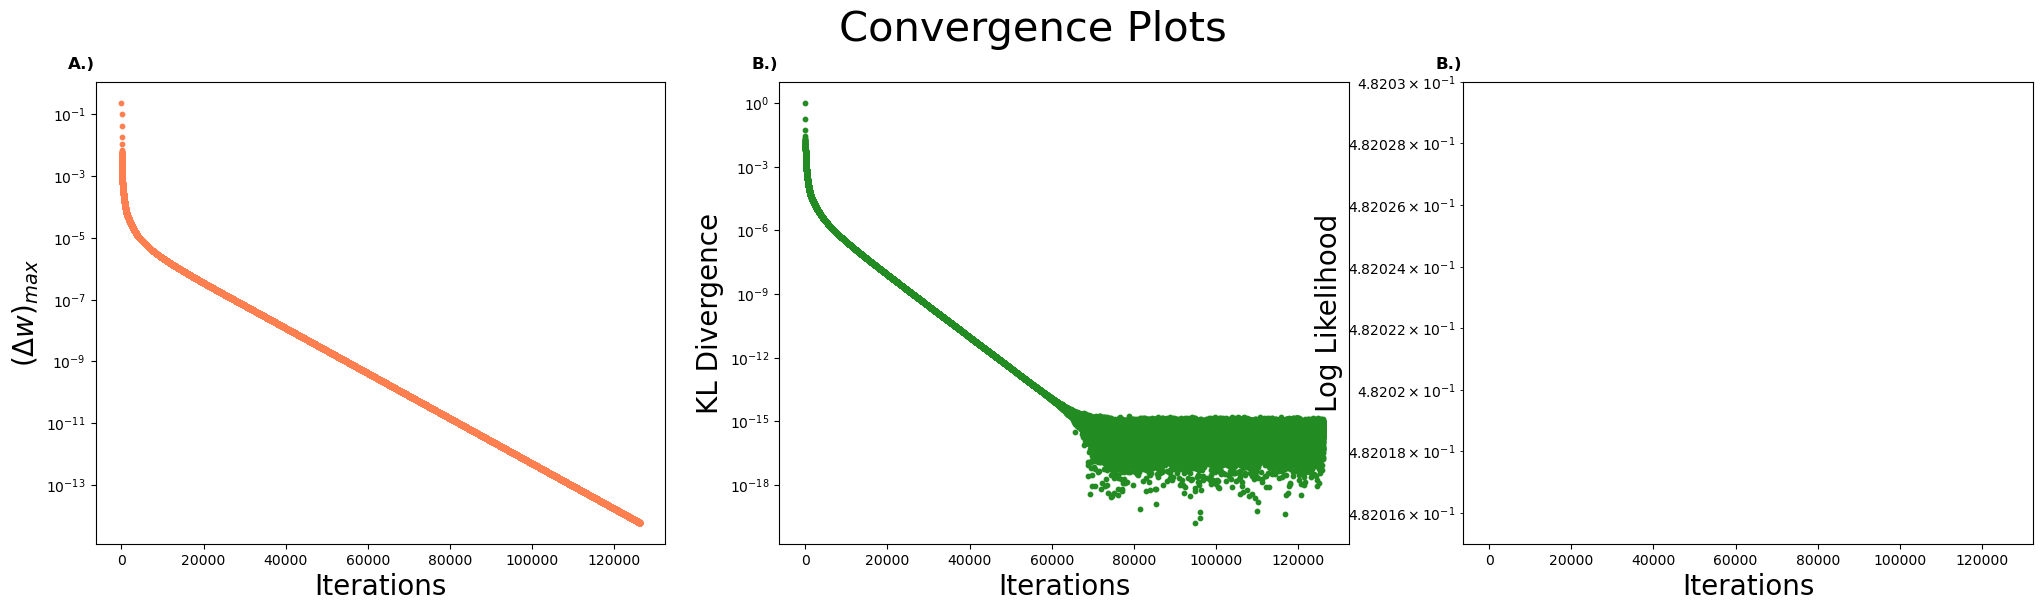

In [21]:
plot(it, Wdiff, kl, lk, title='Convergence Plots', size=10)
plt.savefig('Figures/N Qubit QBM/convergence', bbox_inches='tight')

In [ ]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

# Results 3-qubit system

In [ ]:
#learning parameters
learning_rate = 0.1    #  learning rate 
maxiter  = 200         #  iterations
tolerance = 1e-10      #  tolerance
random_seed = 555
num_qubits = 6

interactions     = generate_interaction_matrices(num_qubits)     #  generate interaction matrices

In [ ]:
interaction_matrices     = generate_interaction_matrices(6)     #  generate interaction matrices]
print(interaction_matrices.shape)

In [ ]:
w, w_eta, KL, Wmax, it = learn_w(interactions, learning_rate, maxiter, tolerance, random_seed, num_qubits)
plot(it, KL, Wmax, title='Convergence Plots', size=10)
plt.savefig('Figures/N Qubit QBM/convergence', bbox_inches='tight')
print(Wmax)

In [ ]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

# Results 4-Qubit system

In [ ]:
#learning parameters
learning_rate       = 0.5      #  learning rate 
maxiter  = 2**16    #  iterations
tolerance      = 1e-10    #  tolerance
random_seed = 555
num_qubits = 4

interactions     = generate_interaction_matrices(num_qubits)     #  generate interaction matrices

In [ ]:
w, w_eta, KL, Wmax, it = learn_w(interaction_matrices, learning_rate, maxiter, tolerance, eta_seed, num_qubits)
plot(it, KL, Wmax, title='Convergence Plots', size=10)
plt.savefig('Figures/N Qubit QBM/convergence', bbox_inches='tight')

In [ ]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

# Test ground